<a href="https://colab.research.google.com/github/d-maniatakos/vaccine-sentiment-classifier/blob/master/vaccine_sentiment_classifier_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vaccine Sentiment Classifier by fine-tuning BERT Model**


---

Διονύσιος Μανιατάκος (Α.Μ: 1115201800104)

## **Modules Import**

In [1]:
!pip install transformers
import torch
from torch import nn
from torch.utils.data import DataLoader

import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 3.5 MB 29.5 MB/s 
     |████████████████████████████████| 596 kB 60.1 MB/s 
     |████████████████████████████████| 6.8 MB 62.1 MB/s 
     |████████████████████████████████| 895 kB 25.8 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## **Data Import**

In [2]:
# read datasets and ignore the first (index) column
train_data =  pd.read_csv('vaccine_train_set.csv').iloc[:, 1:]
validation_data = pd.read_csv('vaccine_validation_set.csv').iloc[:, 1:]    # <--- replace with test set path

train_data.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


## **Prepare Data for BERT**

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

y_train = torch.tensor(train_data['label'].tolist())
y_validation = torch.tensor(validation_data['label'].tolist())

encoded_train = tokenizer.batch_encode_plus(train_data['tweet'].tolist(), add_special_tokens = True, truncation=True, max_length=64, padding='longest', return_attention_mask=True, return_tensors='pt')
encoded_validation = tokenizer.batch_encode_plus(validation_data['tweet'].tolist(), add_special_tokens = True, truncation=True, max_length=64, padding='longest', return_attention_mask=True, return_tensors='pt')

ids_train = encoded_train['input_ids']
ids_validation = encoded_validation['input_ids']

masks_train = encoded_train['attention_mask']
masks_validation = encoded_validation['attention_mask']

train_dataset = torch.utils.data.TensorDataset(ids_train, masks_train, y_train)
validation_dataset = torch.utils.data.TensorDataset(ids_validation, masks_validation, y_validation)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=8, shuffle=True)

## **Model Creation**

In [8]:
device = torch.device('cuda')
torch.cuda.empty_cache()

model = model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## **Model Training**

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), 0.00005)
num_of_epochs = 4

model.train()

training_loss = []
validation_loss = []

for epoch in range(num_of_epochs):
  training_batch_losses = []
  validation_batch_losses = []
  model.train()
  for batch in train_dataloader:
      model.zero_grad()

      ids = batch[0].to(device)
      masks = batch[1].to(device)
      labels = batch[2].to(device)

      out = model(input_ids=ids, attention_mask=masks, labels=labels)
      loss = out['loss']
      training_batch_losses.append(loss.item())

      loss.backward()
      optimizer.step()

  model.eval()
  for batch in validation_dataloader:
      ids = batch[0].to(device)
      masks = batch[1].to(device)
      labels = batch[2].to(device)

      out = model(input_ids=ids, attention_mask=masks, labels=labels)
      loss = out['loss']
      validation_batch_losses.append(loss.item())    

    
  print('Epoch: ' + str(epoch+1) + '/' + str(num_of_epochs) + ' Training Loss: ' + str(round(sum(training_batch_losses)/len(train_dataloader), 4)) + ' Validation Loss: ' + str(round(sum(validation_batch_losses)/len(validation_dataloader), 4)))
  training_loss.append(sum(training_batch_losses)/len(train_dataloader))
  validation_loss.append(sum(validation_batch_losses)/len(validation_dataloader))

  print('----------------------------------------------------------')


Epoch: 1/4 Training Loss: 0.0985 Validation Loss: 1.0906
----------------------------------------------------------


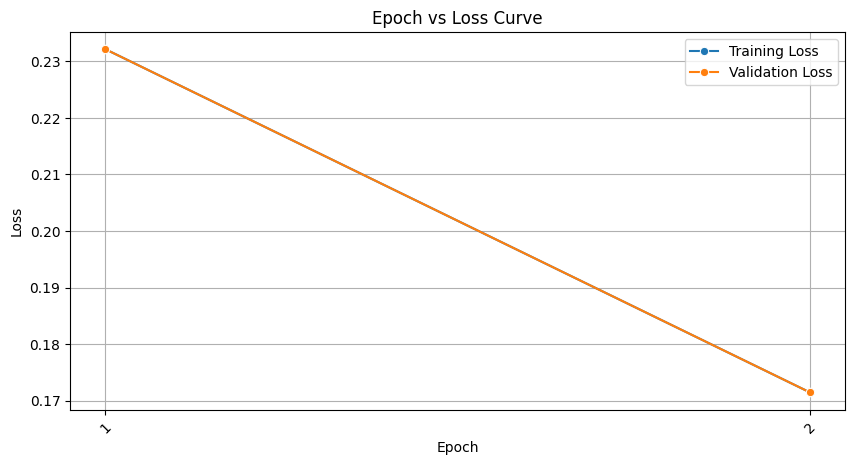

In [19]:
def plot_epoch_vs_loss(num_of_epochs, training_loss, validation_loss):
  plt.figure(figsize=(10, 5), dpi=100)
  plt.title('Epoch vs Loss Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  sns.lineplot(x=range(1, num_of_epochs+1), y=training_loss,  marker="o")
  sns.lineplot(x=range(1, num_of_epochs+1), y=validation_loss,  marker="o")
  plt.xticks(range(1, num_of_epochs+1))
  plt.xticks(rotation=45)
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.grid()
  plt.show()

plot_epoch_vs_loss(num_of_epochs, training_loss, validation_loss)

## **Model Evaluation**

In [ ]:
model.eval()

real_values = []
predictions = []

for batch in validation_dataloader:
  real_values = real_values + batch[2].tolist()
  
  ids = batch[0].to(device)
  masks = batch[1].to(device)
  labels = batch[2].to(device)

  out = model(input_ids=ids, attention_mask=masks, labels=labels)
  predictions = predictions + torch.argmax(out['logits'], dim=1).tolist()

print('Actual Values   : ' + str(real_values))
print('Predicted Values: ' + str(predictions))


Actual Values   : [2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 0, 0, 1, 2, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 2, 1, 1, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 2, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 2, 1, 0, 0, 2, 2, 2, 2, 

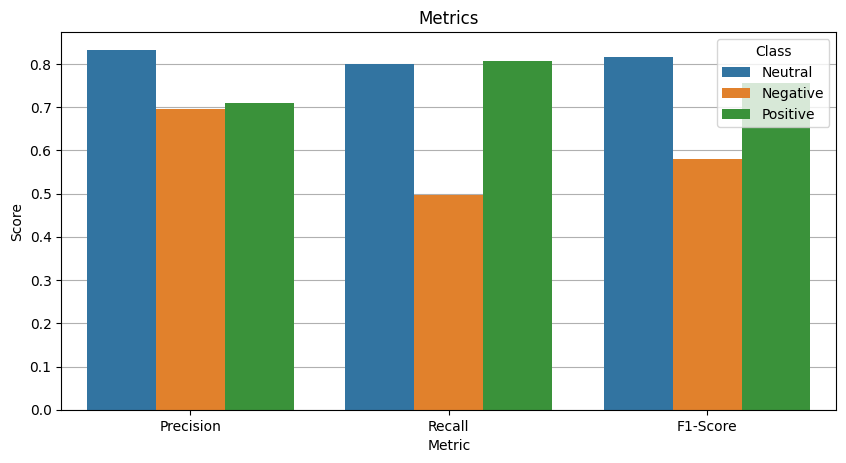

Total Precision: 0.7650814276727885
Total Recall: 0.7633654688869412
Total F1-Score: 0.7606471187374727


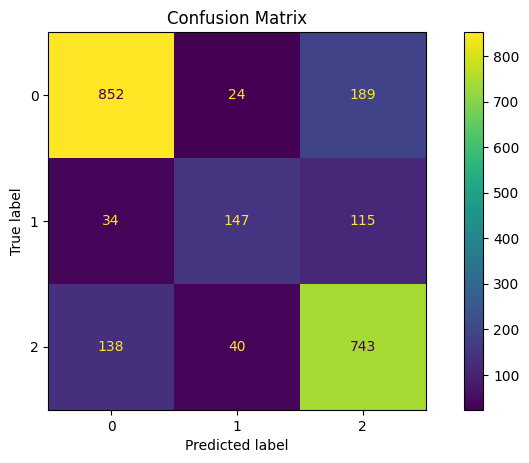

In [ ]:
def compute_metrics(predictions, real_values):
  precisions = []
  recalls = []
  f1_scores = []

  for i in range(3):
    class_preds = list(map(lambda x: 1 if x==i else 0, predictions))
    class_values = list(map(lambda x: 1 if x==i else 0, real_values))
    precisions.append(precision_score(class_values, class_preds))
    recalls.append(recall_score(class_values, class_preds))
    f1_scores.append(f1_score(class_values, class_preds))

  scores_df = pd.DataFrame({'Metric' : ['Precision' , 'Precision', 'Precision', 'Recall', 'Recall', 'Recall', 'F1-Score', 'F1-Score', 'F1-Score'], 
                            'Class' : ['Neutral', 'Negative', 'Positive', 'Neutral', 'Negative', 'Positive', 'Neutral', 'Negative', 'Positive'],
                            'Score' : precisions + recalls + f1_scores})
  
  plt.figure(figsize=(10, 5), dpi=100)
  plt.title('Metrics')
  plt.rc('axes', axisbelow=True)
  plt.grid(zorder=0)
  sns.barplot(y='Score', x='Metric', hue='Class', data=scores_df)
  plt.show()

  print('Total Precision: ' + str(precision_score(real_values, predictions, average='weighted')))
  print('Total Recall: ' + str(recall_score(real_values, predictions, average='weighted')))
  print('Total F1-Score: ' + str(f1_score(real_values, predictions, average='weighted')))

  fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
  plt.title('Confusion Matrix')
  ConfusionMatrixDisplay.from_predictions(real_values, predictions, ax=ax)
  plt.show()

compute_metrics(predictions, real_values)